# Attempt to explain regression predictions

The goal here is to show some ways we can diagnose how confident we are with model predictions - both at the model level (on a test set) and for individual predictions. There are several sources of error that we need to think about when modeling, these techniques (hopefully!) will help us figure out if our errors reside with:
* Sampling - data is poorly recorded in the first place
* Storing - data is transcribed erroneously (e.g. entries are simplified or mis-typed)
* Sparsity - regions of space are poorly explained as we don't have enough data points
* Feature extraction - transforming the data to make it applicable to our modeling technique
* Modeling - the model is too simplistic

Ultimately we need to trust our model and everything it is built on.

This Notebook is a part of my [Data Science Delivered](https://github.com/ianozsvald/data_science_delivered) notes. License: CC-By-Attribution.

This Notebook makes a regressor on the Boston house price dataset and then "explains" some predictions using ELI5 and LIME. It also visualises the model's overall performance and the random forest is "opened up" to test where it works well and where it fails.

Note that this is very much a work in progress, I'm still not super-comfy with ELI5 and LIME so this is to be treated as a work-in-progress.

* Decision trees and feature importances
* yellowbrick (cloned from github 2017-07-28)
* ELI5
* LIME (cloned from github 2017-07-28)

There are other useful notes in this O'Reilly blog post: https://www.oreilly.com/ideas/ideas-on-interpreting-machine-learning

**NOTE** that there are various TODO messages scattered below - I need to fix things like some of the ordering of plots, the colours and the explanations. In particular - I should refactor this to start using LIME and ELI5 earlier to explain a model, then confidence intervals, then model diagnostics, then the technical parts (e.g. RF tree behaviour) at the end

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import eli5 # https://github.com/TeamHG-Memex/eli5 via conda
import lime # https://github.com/marcotcr/lime via PyPI (note this was built using MASTER at time-of-creation)
import yellowbrick # https://github.com/DistrictDataLabs/yellowbrick/ via conda

from eli5 import show_weights
from eli5 import show_prediction

import lime.lime_tabular

from matplotlib import pyplot as plt

%matplotlib inline

/home/ian/anaconda3/envs/data_science_delivered/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# install watermark using
# %install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%load_ext watermark
# show a watermark for this environment
%watermark -d -m -v -p numpy,matplotlib,sklearn,eli5,seaborn,lime,yellowbrick -g

2017-10-08 

CPython 3.6.2
IPython 6.1.0

numpy 1.13.1
matplotlib 2.0.2
sklearn 0.18.2
eli5 0.8
seaborn 0.8.0
lime n
yellowbrick 0.5

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.9.45-040945-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 3c34ccea2ebc85eb7041c9f07b2e31cd805de749


# Load the Boston house prices dataset

* http://www.neural.cz/dataset-exploration-boston-house-pricing.html Some visualisations around this dataset

In [3]:
from sklearn.datasets import load_boston
import sklearn.ensemble
import numpy as np
boston = load_boston()


print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [4]:
df_boston = pd.DataFrame(boston.data, columns=boston.feature_names)
df_boston = pd.concat((df_boston, pd.DataFrame(boston.target, columns=['MEDV'])), axis=1)
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Median value is non-Gaussian distributed with many lower-priced properties and very few high-priced properties

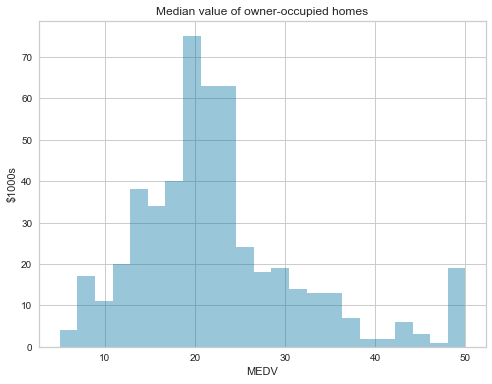

In [5]:
fig, ax = plt.subplots(figsize=(8,6)); 
sns.distplot(df_boston.MEDV, kde=False, ax=ax);
ax.set_ylabel("$1000s");
ax.set_title("Median value of owner-occupied homes");

### Median value increases strongly if the lower-status percentage is low, lower-value properties are typically owned in areas with a higher percentage of lower-status people

The relationship is roughly linear but is best exploited by a non-linear estimator.

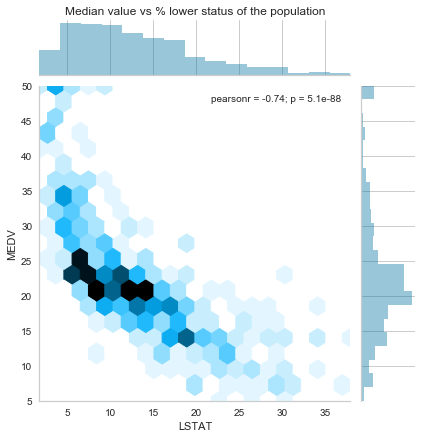

In [126]:
jg = sns.jointplot(df_boston.LSTAT, df_boston.MEDV, kind='hex')
jg.ax_marg_x.set_title("Median value vs % lower status of the population");

### Median value increases as the average number of rooms per property increases 

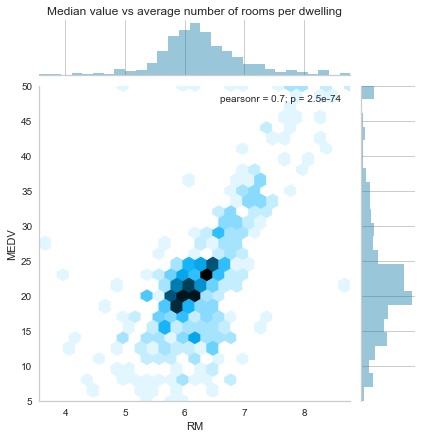

In [127]:
jg = sns.jointplot(df_boston.RM, df_boston.MEDV, kind='hex')
jg.ax_marg_x.set_title("Median value vs average number of rooms per dwelling");

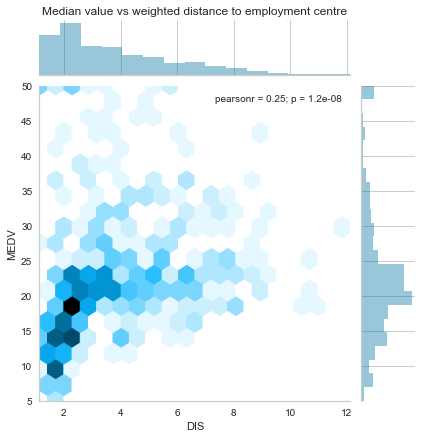

In [128]:
jg = sns.jointplot(df_boston.DIS, df_boston.MEDV, kind='hex')
jg.ax_marg_x.set_title("Median value vs weighted distance to employment centre");

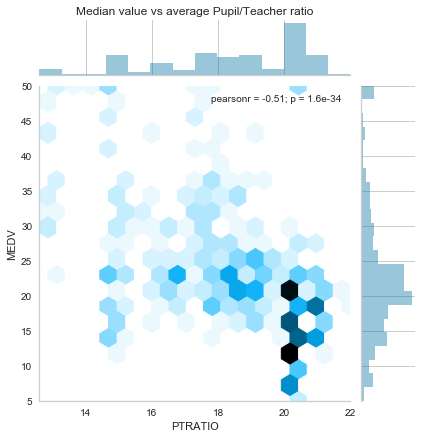

In [129]:
jg = sns.jointplot(df_boston.PTRATIO, df_boston.MEDV, kind='hex')
jg.ax_marg_x.set_title("Median value vs average Pupil/Teacher ratio");

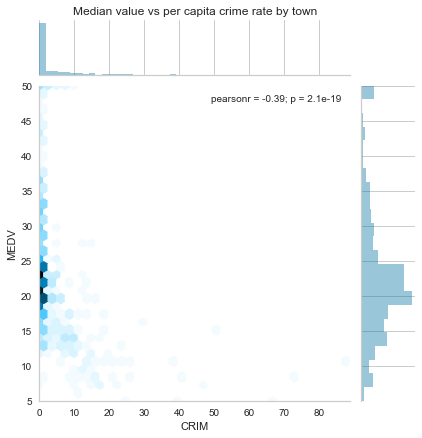

In [135]:
jg = sns.jointplot(df_boston.CRIM, df_boston.MEDV, kind='hex')
jg.ax_marg_x.set_title("Median value vs per capita crime rate by town");

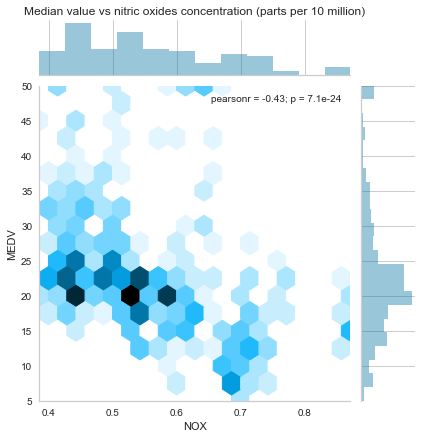

In [136]:
jg = sns.jointplot(df_boston.NOX, df_boston.MEDV, kind='hex')
jg.ax_marg_x.set_title("Median value vs nitric oxides concentration (parts per 10 million)");

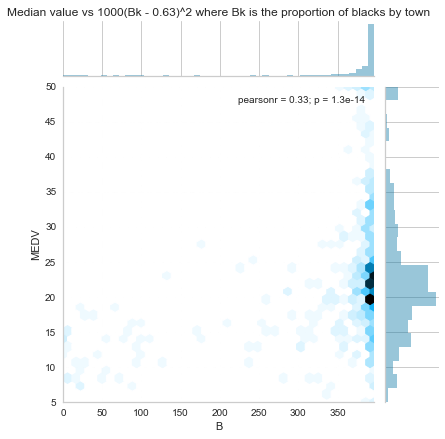

In [140]:
jg = sns.jointplot(df_boston.B, df_boston.MEDV, kind='hex')
jg.ax_marg_x.set_title("Median value vs 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town");

# Sanity check the train / test data

In [8]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_boston.drop('MEDV', axis=1), 
                                                                            df_boston['MEDV'],
                                                                            train_size=0.8,
                                                                            random_state=0)

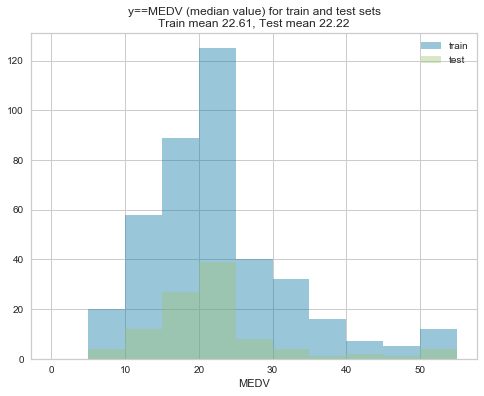

In [9]:
fig, ax = plt.subplots(figsize=(8,6)); 
bins=range(0, 56, 5)
sns.distplot(y_train, kde=False, ax=ax, label="train", bins=bins);
sns.distplot(y_test, kde=False, ax=ax, label="test", bins=bins);
ax.legend();

ax.set_title("y==MEDV (median value) for train and test sets\nTrain mean {:0.2f}, Test mean {:0.2f}".format(y_train.mean(), y_test.mean()));

# Build small RandomForestRegressor

In [56]:
# this is a deliberately limited regressor to keep things simple
est = sklearn.ensemble.RandomForestRegressor(n_estimators=100,
                                             #max_depth=30,
                                             random_state=0)

print("Sizes for train {}, test {}".format(X_train.shape, X_test.shape))
est.fit(X_train, y_train)


Sizes for train (404, 13), test (102, 13)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [57]:
from sklearn.metrics import mean_squared_error
mse_test = mean_squared_error(y_test, est.predict(X_test))

print('Random Forest mean-squared error on test set:', mse_test)

Random Forest mean-squared error on test set: 18.5465257451


## Reviewing confidence intervals via forestci

Which regions of our regression space have _good_ estimates and where might we not trust them?

Inspiration: 
 * http://contrib.scikit-learn.org/forest-confidence-interval/auto_examples/plot_mpg.html#sphx-glr-auto-examples-plot-mpg-py
 * http://contrib.scikit-learn.org/forest-confidence-interval/

An unbiased estimate of variance is calculated for each point in the test set. Some regions have a large variance, this is shown using the true MEDV value (on the x axis) with a large symmetric error bar.

Since the error bars can go negative and we're dealing with house prices (which _should_ only be positive) we'll have to take this with a grain of salt.

I'd love to hear if there's a better way of thinking about variance in uncertain regions _especially_ if we can sensibly avoid having negative price predictions. 

/home/ian/anaconda3/envs/data_science_delivered/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


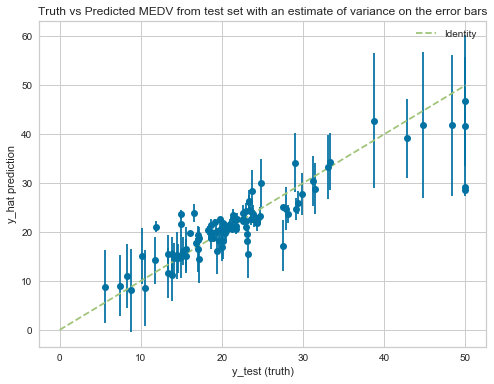

In [58]:
import forestci as fci
#inbag = fci.calc_inbag(X_train.shape[0], est)

V_IJ_unbiased = fci.random_forest_error(est, X_train, X_test)

y_hat = est.predict(X_test)
fig, ax = plt.subplots(figsize=(8,6)); 
ax.errorbar(y_test, y_hat, yerr=np.sqrt(V_IJ_unbiased), fmt='o');
ax.set(title="Truth vs Predicted MEDV from test set with an estimate of variance on the error bars",
       xlabel="y_test (truth)",
       ylabel="y_hat prediction");
plt.plot([0, 50], [0, 50], '--', label="Identity");
plt.legend();

If we plot the variance over the MEDV range we can see that for higher MEDV values the variance is very high (and so potentially we can't trust these predictions).

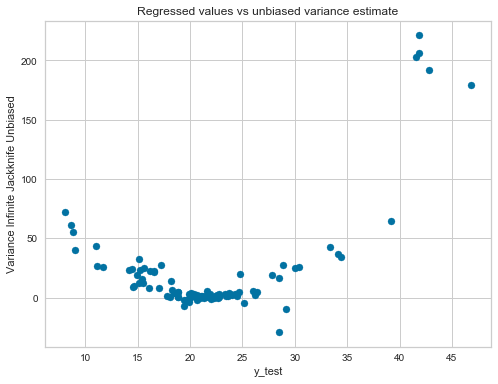

In [59]:
fig, ax = plt.subplots(figsize=(8,6)); 
ax.scatter(y_hat, V_IJ_unbiased);
ax.set(title="Regressed values vs unbiased variance estimate", 
       xlabel="y_test", 
       ylabel="Variance Infinite Jackknife Unbiased");

## Look at estimator's tree estimates over a range of test values

First we build a subsample of the testing data including the smallest and largest MEDV examples and a random sample of items inbetween.

In [60]:
samples_all = pd.concat((pd.DataFrame(X_test), pd.DataFrame(y_test)), axis=1).sort_values('MEDV')
samples_middle = samples_all[1:-1]
samples = pd.concat((pd.DataFrame(samples_all.iloc[0]).T, samples_middle.sample(10, random_state=3), pd.DataFrame(samples_all.iloc[-1]).T), axis=0) #, samples_all.iloc[0]))
print("Working off of {} samples".format(samples.shape))
samples = samples.sort_values('MEDV')
#.sample(10).
X_samples = samples.drop('MEDV', axis=1)
y_samples = samples['MEDV']

yhat_samples = est.predict(X_samples)

nbr_estimators = len(est.estimators_)
estimates_by_tree = {}
for tree_nbr in range(nbr_estimators):   
    tree = est.estimators_[tree_nbr]
    yhat_samples_by_tree = tree.predict(X_samples)
    estimates_by_tree[tree_nbr] = yhat_samples_by_tree
    
df_estimates_by_tree = pd.DataFrame(estimates_by_tree)
df_estimates_by_tree = df_estimates_by_tree.T

Working off of (12, 14) samples


#### Boxplot each of the samples by truth value and show the range of tree estimates for each example

Note that the extremes the Prediction (blue cross) is over or under predictive of the Truth (green cross). The box plot shows the inter-quartile range of the estimates made by each tree inside the Random Forest. Note that sometimes (e.g. example 10) the blue cross (Prediction) is _outside_ of the box - we'll dig into this in the following cell.

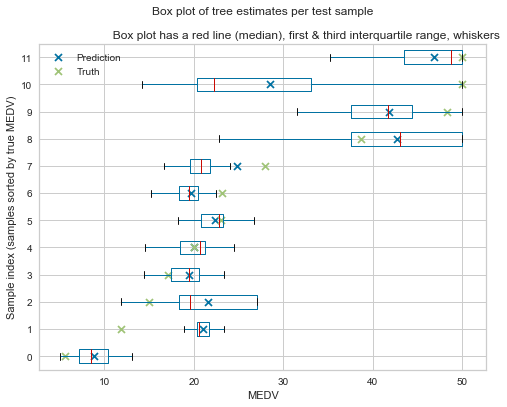

In [61]:
fig, ax = plt.subplots(figsize=(8,6)); 

# note that if we enable showmeans and meanline then the boxplot will
# show a dotted line for the mean (the solid red line is the median)
# and this matches the Prediction cross that I've subsequently drawn
df_estimates_by_tree.plot(kind="box", vert=False, ax=ax, 
                          title="""Box plot of tree estimates per test sample\n
                          Box plot has a red line (median), first & third interquartile range, whiskers""");
                          #showmeans=True, meanline=True);
ax.set(xlabel="MEDV", ylabel="Sample index (samples sorted by true MEDV)");
y_indices = list(range(1, y_samples.shape[0]+1))
ax.scatter(yhat_samples, y_indices, marker='x', label="Prediction");
ax.scatter(y_samples.values, y_indices, marker='x', label="Truth");
ax.legend();

Rather than drawing the boxplot we can draw the individual estimates from each of the trees. Note that whilst they _should_ be clustered together (so taking the mean for the Random Forest result makes sense) sometimes they're widely distributed. For example 10 (sorry - inverted plot! **TODO** fix this) we can see a minority of trees predict 50 whilst the majority predict around 21-25, hence the mean is dragged high between the two clusters. 

This should give us a clue that our model is sometimes underfitting. 

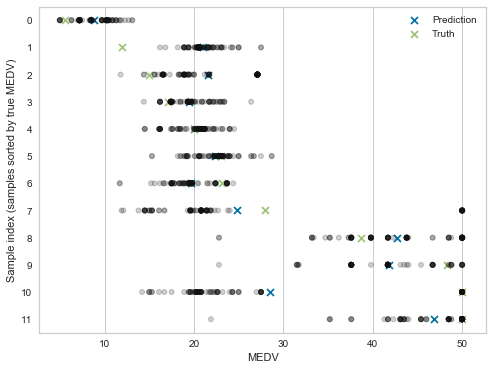

In [62]:
fig, ax = plt.subplots(figsize=(8,6)); 
sns.stripplot(data=df_estimates_by_tree, jitter=0.0, orient="h", ax=ax, edgecolor="k", 
              linewidth=1, color='k', alpha=0.2);

ax.set(xlabel="MEDV", ylabel="Sample index (samples sorted by true MEDV)");
y_indices = list(range(y_samples.shape[0]))
ax.scatter(yhat_samples, y_indices, marker='x', label="Prediction");
ax.scatter(y_samples.values, y_indices, marker='x', label="Truth");
ax.legend();

We can plot the Variance on the same sample set (as used in the above two plots). Example 10 shows a lower variance (presumably because most of the estimators cluster their prediction together), which is disappointing

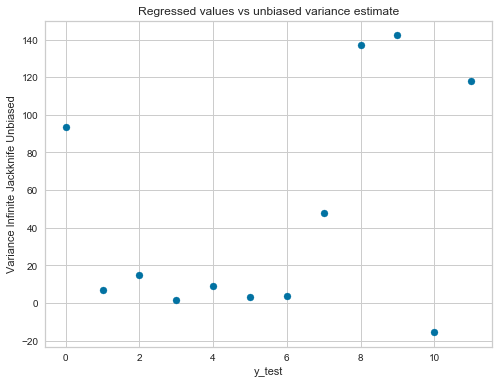

In [63]:
V_IJ_unbiased = fci.random_forest_error(est, X_train, X_samples)
y_hat = est.predict(X_samples)

fig, ax = plt.subplots(figsize=(8,6)); 
ax.scatter(y_indices, V_IJ_unbiased);
ax.set(title="Regressed values vs unbiased variance estimate", 
       xlabel="y_test", 
       ylabel="Variance Infinite Jackknife Unbiased");

**TODO** add a plot showing, for each row, the (max_estimate-min_estimate) as another way of showing where we potentially have poor estimates overall

# Use LIME to explain a previously-unseen example from the test set

* http://lime-ml.readthedocs.io/en/latest/lime.html
* http://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_tabular.LimeTabularExplainer.explain_instance
* http://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_base.LimeBase.explain_instance_with_data
* `explain_instance` https://github.com/marcotcr/lime/blob/master/lime/lime_base.py#L166

In [207]:
example_to_explain_idx = 14
example_to_explain = X_test.iloc[example_to_explain_idx]
example_to_explain_true_answer = y_test.iloc[example_to_explain_idx]
feature_names = boston.feature_names

print("Explaining the {}th row from the testing set".format(example_to_explain_idx))

Explaining the 14th row from the testing set


We'll ask LIME to explain (with a locally-built linear model) the decision of the Random Forest Regressor. We have the truth (from `y_test`) and the RF estimator's learned output (`predicted answer`). As long as LIME's answer is fairly similar to the `predicted answer` then we can _probably_ trust the explanation that is generated.

In [208]:
print("The answer we're looking for is: ", example_to_explain_true_answer)
print("The predicted answer is:", float(est.predict(example_to_explain.values.reshape(-1, 1).T)))
print("The input data X is: ")

pd.DataFrame(example_to_explain)

The answer we're looking for is:  50.0
The predicted answer is: 46.808
The input data X is: 


,162
CRIM,1.83377
ZN,0.00000
INDUS,19.58000
CHAS,1.00000
NOX,0.60500
RM,7.80200
AGE,98.20000
DIS,2.04070
RAD,5.00000
TAX,403.00000


In [209]:
categorical_features = np.argwhere(np.array([len(set(boston.data[:,x])) for x in range(boston.data.shape[1])]) <= 10).flatten()

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=feature_names, 
                                                   class_names=['price'], 
                                                   categorical_features=categorical_features, 
                                                   verbose=True, 
                                                   mode='regression')

* Uses perturbed data `neighborhood_data` and `neighborhood_labels`
* `Intercept` is the generated linear model's intercept
* `Prediction_local` is the predicted output from the linear model
* `Right` is the predicted value from the explained regressor (not LIME's linear model)

In [210]:
exp = explainer.explain_instance(example_to_explain, est.predict, num_features=10)

Intercept 20.0913569362
Prediction_local [ 34.53523088]
Right: 46.808


On the 0th test example LIME shows LSTAT and RM as being the most important features. On multiple runs I see different answers but LSTAT and RM are consistently the most important.

In the following 2 or 3 cells we can see that the `Intercept` is approximately the average answer of the training set (and presumably is biased by the local samples relative to the point we're explaining), any `positive` features will add to the `Intercept` value and any `negative` features will subtract from it. The final sum will equal the `Prediction_local` value. As such we can see that `LSTAT` (which is between approx. 6.7 and 11.3) has the largest positive contribution for the 0th example and `RM` (which is between approx. 6.2 and 6.7) has a slightly smaller negative contribution.

Features like "6.73 <= LSTAT < 11.30" _I believe_ are generated by the quartile-range binning in LIME to generate binned feature sets.

An example of a screenshot of the following output can be found in this bug report: https://github.com/marcotcr/lime/issues/88

If this is rendered locally then you'll see:
* Predicted value and a min/max range
* Negative and positive explanatory features (also shown below for `as_pyplot_figure`) sorted most-important-first
* Features & values from the input (`example_to_explain`) sorted by feature importance

In [211]:
# NOTE that the following HTML table doesn't render in GitHub so online this
# will be blank - locally it looks very pretty!
exp.show_in_notebook(show_table=True)

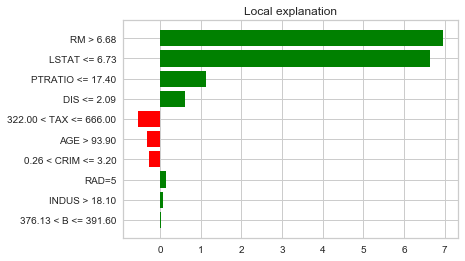

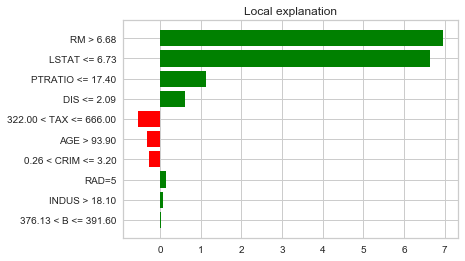

In [212]:
exp.as_pyplot_figure() # note that the double-plot is a bug: https://github.com/marcotcr/lime/issues/89

In [213]:
exp.as_list() # we can extract a programmatic version if we want to make our own decisions

[('RM > 6.68', 6.9536776693228566),
 ('LSTAT <= 6.73', 6.6374820245236794),
 ('PTRATIO <= 17.40', 1.1319189819920588),
 ('DIS <= 2.09', 0.61088467853086303),
 ('322.00 < TAX <= 666.00', -0.53362899533897501),
 ('AGE > 93.90', -0.33128527443425054),
 ('0.26 < CRIM <= 3.20', -0.26226374443315559),
 ('RAD=5', 0.13939398096845898),
 ('INDUS > 18.10', 0.064875875752381421),
 ('376.13 < B <= 391.60', 0.032818749899940776)]

# Use ELI5 to explain an example

ELI5 walks the Random Forest decisions to derive an explanation in a different way to LIME's approach.

The BIAS shoule be the mean of the training dataset (although I've seen it vary a bit which leaves me confused - see http://blog.datadive.net/interpreting-random-forests/ ).

On the 0th test example the explanation shows LSTAT and RM as the most important features. LSTAT contributes a positive value and RM subtracts a value, DIS is marked as important but makes only a small negative contribution.

In [214]:
print("BIAS is the mean of the training data (i.e. a guess prior to using any features):", y_train.mean())

BIAS is the mean of the training data (i.e. a guess prior to using any features): 22.6118811881


In [216]:
show_prediction(est, 
                example_to_explain, 
                feature_names=feature_names, 
                show_feature_values=True)

# Visualising the model's feature importances 

### Check the raw feature importances

In [102]:
df = pd.DataFrame({'feature_importances_': est.feature_importances_}, index=boston.feature_names)
df.sort_values(by="feature_importances_", ascending=False).head(5)

,feature_importances_
RM,0.421308
LSTAT,0.408152
CRIM,0.037026
DIS,0.035992
NOX,0.022442


### Use ELI5's importance visualiser

Note that the +/- value assumes a Gaussian and the boxplot below shows that this isn't true (also discussed here https://mail.python.org/pipermail/scikit-learn/2017-June/001615.html )

**TODO** Ian - consider filing a bug against this.

In [103]:
show_weights(est, feature_names=feature_names)

Weight,Feature
0.4213 ± 0.4365,RM
0.4082 ± 0.4247,LSTAT
0.0370 ± 0.0570,CRIM
0.0360 ± 0.0609,DIS
0.0224 ± 0.0368,NOX
0.0224 ± 0.0294,PTRATIO
0.0158 ± 0.0187,TAX
0.0117 ± 0.0188,AGE
0.0092 ± 0.0138,B
0.0081 ± 0.0150,INDUS


### ELI5's Permutation Importance on the same features

* http://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html#eli5-permutation-importance

In [29]:
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(est).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.5257 ± 0.2220,LSTAT
0.3951 ± 0.0788,RM
0.1001 ± 0.0267,DIS
0.0121 ± 0.0064,CRIM
0.0117 ± 0.0133,B
0.0089 ± 0.0115,PTRATIO
0.0062 ± 0.0171,NOX
0.0022 ± 0.0057,TAX
0.0017 ± 0.0048,INDUS
0.0007 ± 0.0023,RAD


## Feature importance as a box plot

We can plot the feature importances from the Random Forest model using the random forest mean but I think it is far more informative to look at the distribution of each contributing tree's feature importances in a box plot.

We can see that the distribution of importances for LSTAT and RM is fairly wide.

### Boxplot of Feature Importances developed per tree

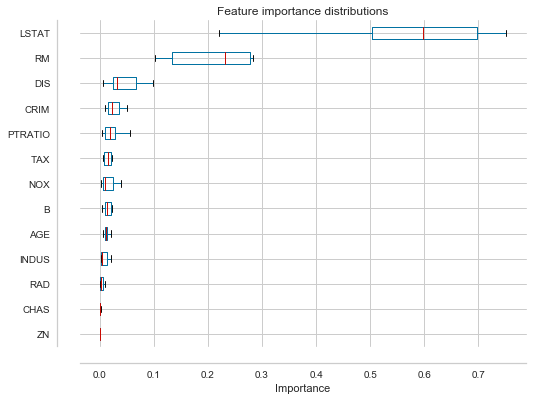

In [30]:
df = pd.DataFrame()
for est_idx, est_tree in enumerate(est.estimators_):
    df["tree_{}".format(est_idx)] = est_tree.feature_importances_
df = df.set_index(boston.feature_names)
df = df.T # transpose the dataframe

sorted_index = df.mean(axis=0).sort_values().index

fig, ax = plt.subplots(figsize=(8,6)); 
df[sorted_index].plot(kind="box", vert=False, ax=ax, title="Feature importance distributions");
ax.set_xlabel("Importance")

# remove right/top border to make things slightly neater
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# visual tidy-up to make left axis small values slightly easier to read
# offset left and bottom axis
ax.spines['bottom'].set_position(('axes', -0.05))
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('axes', -0.05))

### A strip-plot shows the outliers more clearly than the box-plot itself

Going a step further if we add the values of each tree's feature importance calculation we can see that sometimes LSTAT and RM have very different importances. Presumably this depends on the sub-sample of examples that are being trained on.

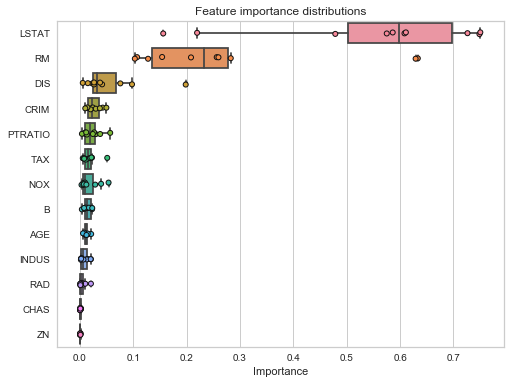

In [31]:
fig, ax = plt.subplots(figsize=(8,6)); 
sns.stripplot(data=df[sorted_index[::-1]], jitter=0.05, orient="h", ax=ax, edgecolor="k", linewidth=1);
sns.boxplot(data=df[sorted_index[::-1]], orient="h", ax=ax);
ax.set_title("Feature importance distributions");
ax.set_xlabel("Importance")

### Show individual predictions from each tree in the estimator

We can ask each of the Random Forest's trees for their individual regression predictions (the bar chart) and then we can take the mean (the red line). This gives us an idea of how the Random Forest's predictions are constructed.

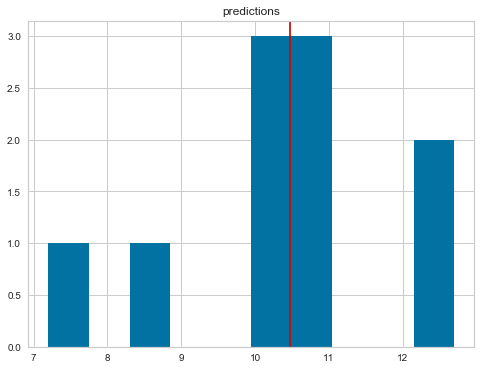

In [32]:
example = example_to_explain.values.reshape((1,-1))
ensemble_prediction = est.predict(example)

predictions = []
for tree in est.estimators_:
    predictions.append(tree.predict(example))
    
df_predictions = pd.DataFrame(predictions, columns=['predictions'])

fig, ax = plt.subplots(figsize=(8,6)); 
df_predictions.hist(ax=ax)

ax.axvline(x=ensemble_prediction, c="r");

## Examine the weights of a single tree from the ensemble

In [33]:
show_weights(est, feature_names=feature_names, show="description")

In [34]:
est_depth_3 = sklearn.ensemble.RandomForestRegressor(n_estimators=10,
                                             max_depth=3,
                                             random_state=0)

print("Sizes for train {}, test {}".format(X_train.shape, X_test.shape))
est_depth_3.fit(X_train, y_train)


est_tree0 = est_depth_3.estimators_[0]

Sizes for train (404, 13), test (102, 13)


Note that these _should_ work according to docs but I can't get a result:
```
* 'targets' - per-target feature weights;
* 'transition_features' - transition features of a CRF model;
* 'feature_importances' - feature importances of a decision tree or
  an ensemble-based estimator;
* 'decision_tree' - decision tree in a graphical form;
* 'method' - a string with explanation method;
* 'description' - description of explanation method and its caveats.
```

In [35]:
show_weights(est_tree0, feature_names=feature_names)

Weight,Feature
0.7166,LSTAT
0.2356,RM
0.0242,NOX
0.0237,DIS
0,B
0,PTRATIO
0,TAX
0,RAD
0,AGE
0,CHAS


# Visualise test-set errors

Using YellowBrick we can show the residuals (difference between the predicted value and the truth) both for the training set and the testing set (respectively blue and green). 

If the training and testing residuals had a different distribution it might indicate various problems:
* small training residuals and large testing residuals might indicate over-fitting
* differing distributions of values along the x axis might suggest that the training and testing values don't represent similar samples
* the size of the residuals at certain points in the range might be very-wrong suggesting poor model convergence in these areas

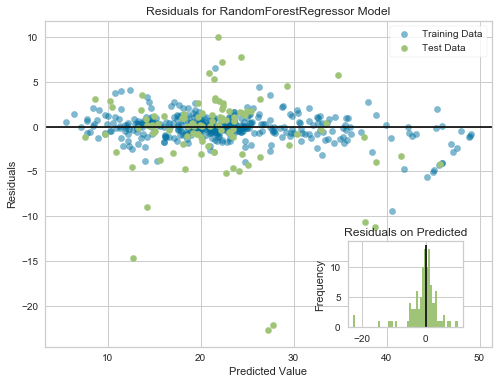

In [36]:
from yellowbrick.regressor import PredictionError, ResidualsPlot

fig, ax = plt.subplots(figsize=(8,6)); 
visualizer = ResidualsPlot(est, ax=ax)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data


# add histogram of residual errors
# https://github.com/DistrictDataLabs/yellowbrick/issues/264
left, bottom, width, height = [0.65, 0.17, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

# we could plot the training residuals behind the testing residuals
# (but here we have 80% train, 20% test, so the y-axis is offset and this looks less useful)
#training_residuals = pd.Series(est.predict(X_train) - y_train)
#training_residuals.plot(kind="hist", bins=50, title="", ax=ax2, color='b', alpha=1);

testing_residuals = pd.Series(est.predict(X_test) - y_test)
testing_residuals.plot(kind="hist", bins=50, title="Residuals on Predicted", ax=ax2, color='g', alpha=1);
ax2.vlines(0, ymin=0, ymax=ax2.get_ylim()[1] ) # add x==0 line

g = visualizer.poof()             # Draw/show/poof the data

### Plotting truth vs residuals

This is related to the plot above, here we plot residuals against the truth (as opposed to plotting against the prediction). It looks from MEDV>40 the predictions are under-estimates of the true values. 

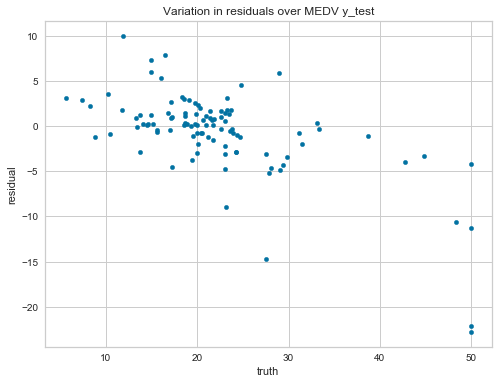

In [37]:
testing_residuals.values # residual between prediction and truth
y_test.values

dfx = pd.DataFrame({'residual': testing_residuals.values, 'truth': y_test.values})
fig, ax = plt.subplots(figsize=(8,6)); 

dfx.plot(kind="scatter", x='truth', y='residual', ax=ax, title="Variation in residuals over MEDV y_test")


### PredictionError against the truth

If the predictions are very closely matching the truth then we'll have a 45 degree line. Here it looks as though our model under-predicts the truth. 

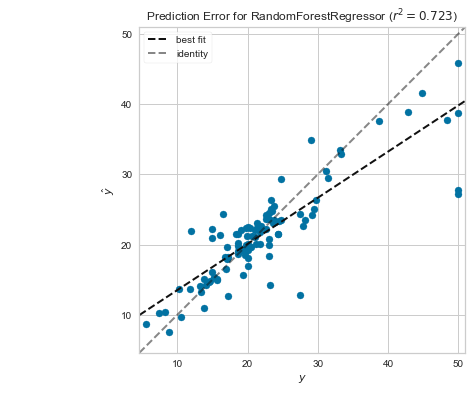

In [38]:
fig, ax = plt.subplots(figsize=(8,6)); 

visualizer = PredictionError(est, ax=ax)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

# Plotting _independent_ histograms of y_test vs predictions 

If the Truth and Predictions align then the cumulative plots will overlap. Here we have under-predictions followed by over-predictions, the overlap is visible over the range of MEDV.

Note that we're plotting two independent histograms, so the predictions and truths aren't aligned. Here we're just checking to see if the predictions and the truth "look similar". Our distributions do look different, so this is a simple test to see that things aren't quite as we'd like them to be.

**TODO** create a difference of cumulative-lines plot, to show the under/over swing. Fix the very light colours!

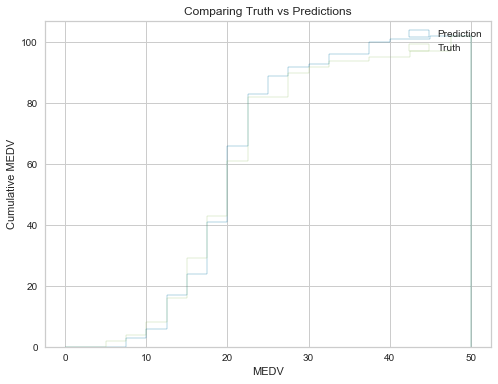

In [39]:
fig, ax = plt.subplots(figsize=(8,6)); 

rng = (0, 50)
bins = 20
histtype = "step"
ax.hist(est.predict(X_test), label="Prediction", range=rng, bins=bins, cumulative=True, histtype=histtype);
ax.hist(y_test, label="Truth", range=rng, bins=bins, cumulative=True, histtype=histtype);
ax.set(title="Comparing Truth vs Predictions", xlabel="MEDV", ylabel="Cumulative MEDV")
ax.legend();

# Making fake samples to try to get a "feel" for the space

We can sample around the local feature space for the point that we're explaining, drawing a contour plot of the estimated MEDV in the local area. There's no guarantee that we're getting this "right" (as we're only changing two of many features) but since for this case we only have two important features, we're probably-not-too-wrong. 

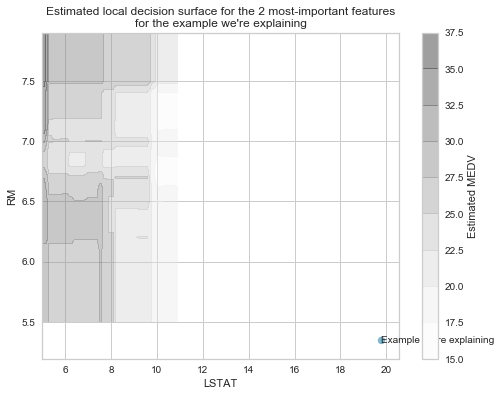

In [40]:
lstat_min = 5
lstat_max = 11
rm_min = 5.5
rm_max = 8

x_min = lstat_min
x_max = lstat_max
y_min = rm_min
y_max = rm_max

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

fig, ax = plt.subplots(figsize=(8,6)); 

Z = []
fake_example_to_explain = example_to_explain.copy()
for new_x, new_y in np.c_[xx.ravel(), yy.ravel()]:
    fake_example_to_explain.LSTAT = new_x
    fake_example_to_explain.RM = new_y
    MEDV_fake_example = est.predict(fake_example_to_explain.values.reshape(-1, 1).T)
    Z.append(MEDV_fake_example)

Z = np.array(Z).reshape(xx.shape)
cont = ax.contourf(xx, yy, Z, alpha=0.4)
ax.set(xlabel="LSTAT", 
       ylabel="RM", 
       title="Estimated local decision surface for the 2 most-important features\nfor the example we're explaining");

plt.scatter([example_to_explain.LSTAT], [example_to_explain.RM], alpha=0.5)
ax.text(example_to_explain.LSTAT, example_to_explain.RM, "Example we're explaining", ha="left", va="center")
fig.colorbar(cont, ax=ax, orientation='vertical', label="Estimated MEDV");

# Odd case one - high valued row 1

Note if we try to predict `example_to_explain_idx = 1` (MEDV==50), the estimator gives a large error by under-predicting. The following bar chart will show that most of the trees are predicting a very low value, only a few are predicting a high value. The wide and multi-modal nature of this distribution may give us a diagnostic clue.

In [41]:
example_to_explain_idx = 1
example_to_explain = X_test.iloc[example_to_explain_idx]
example_to_explain_true_answer = y_test.iloc[example_to_explain_idx]
feature_names = boston.feature_names

print("Explaining the {}th row from the testing set".format(example_to_explain_idx))

print("The answer we're looking for is: ", example_to_explain_true_answer)
print("The predicted answer is:", float(est.predict(example_to_explain.values.reshape(-1, 1).T)))
print("The input data X is: ")

pd.DataFrame(example_to_explain)

Explaining the 1th row from the testing set
The answer we're looking for is:  50.0
The predicted answer is: 27.82
The input data X is: 


,371
CRIM,9.2323
ZN,0.0000
INDUS,18.1000
CHAS,0.0000
NOX,0.6310
RM,6.2160
AGE,100.0000
DIS,1.1691
RAD,24.0000
TAX,666.0000


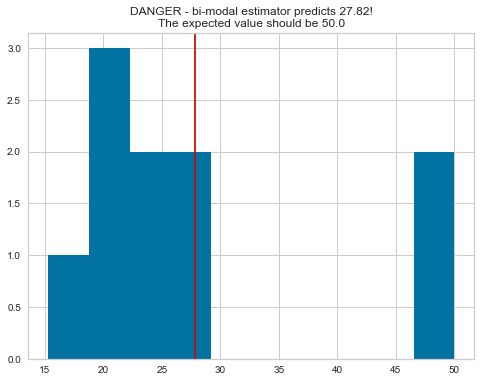

In [42]:
example = example_to_explain.values.reshape((1,-1))

ensemble_prediction = est.predict(example)

predictions = []
for tree in est.estimators_:
    predictions.append(tree.predict(example))
    
df_predictions = pd.DataFrame(predictions, columns=['predictions'])

fig, ax = plt.subplots(figsize=(8,6)); 
df_predictions.hist(ax=ax)

ax.axvline(x=ensemble_prediction, c="r");

ax.set_title("DANGER - bi-modal estimator predicts {}!\nThe expected value should be {}".format(ensemble_prediction[0], example_to_explain_true_answer));

# To Add

* Read http://blog.datadive.net/interpreting-random-forests/ and use to augment the ELI5 description
* Add to LIME regression notes https://marcotcr.github.io/lime/tutorials/Using%2Blime%2Bfor%2Bregression.html and https://github.com/marcotcr/lime notes on applying feature probabilities to the class, read their notes https://github.com/marcotcr/lime/issues/3
* Iterate over each tree's prediction path
* Try https://github.com/andosa/treeinterpreter (older, apparently does support regression) and see if http://blog.datadive.net/random-forest-interpretation-with-scikit-learn/ has value to ELI5
* Investigate https://github.com/slundberg/shap Shapley models for explanations
* Consider adding Logistic Regression + Confidence Interval: http://efavdb.com/logistic-regression/
* Consider adding Gradient Boosted Machine with Partial Dependence Plot
* Add confusion matrix of grouped values (perhaps?)

# Confirm Notebook ran to completion

In [43]:
print("Completed running this Notebook at:", datetime.datetime.now())

Completed running this Notebook at: 2017-10-08 12:29:55.647178


# Appendix - Unfinished ideas

# Iterate over the decision path in each estimator

**TODO** iterate over the steps in decision making, print the decisions that are made

* https://stackoverflow.com/questions/20156951/how-do-i-find-which-attributes-my-tree-splits-on-when-using-scikit-learn
* http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

In [44]:
example = example_to_explain.values.reshape((1,-1))
est_tree0 = est.estimators_[0]

print(est_tree0.predict(example))

# we have 15 nodes, this set of decisions has 15 steps
# "Return a node indicator matrix where non zero elements indicates that the samples goes through the nodes."
decisions = np.array(est_tree0.decision_path(example).todense())[0,:]
decisions

[ 22.9]


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

In [45]:
clf = est_tree0
X=pd.DataFrame(X_test)
list(zip(X.columns[clf.tree_.feature], clf.tree_.threshold, clf.tree_.children_left, clf.tree_.children_right))

[('LSTAT', 8.130000114440918, 1, 170),
 ('RM', 6.9019999504089355, 2, 97),
 ('DIS', 1.4849499464035034, 3, 4),
 ('B', -2.0, -1, -1),
 ('RM', 6.5434999465942383, 5, 62),
 ('LSTAT', 7.809999942779541, 6, 53),
 ('TAX', 222.5, 7, 8),
 ('B', -2.0, -1, -1),
 ('DIS', 4.4637999534606934, 9, 20),
 ('CRIM', 4.5488948822021484, 10, 19),
 ('CHAS', 0.5, 11, 18),
 ('AGE', 94.0, 12, 17),
 ('RM', 6.4679999351501465, 13, 16),
 ('B', 396.614990234375, 14, 15),
 ('B', -2.0, -1, -1),
 ('B', -2.0, -1, -1),
 ('B', -2.0, -1, -1),
 ('B', -2.0, -1, -1),
 ('B', -2.0, -1, -1),
 ('B', -2.0, -1, -1),
 ('AGE', 42.849998474121094, 21, 46),
 ('B', 394.114990234375, 22, 41),
 ('CRIM', 0.10960499942302704, 23, 34),
 ('LSTAT', 6.0199999809265137, 24, 29),
 ('RAD', 4.5, 25, 26),
 ('B', -2.0, -1, -1),
 ('PTRATIO', 17.5, 27, 28),
 ('B', -2.0, -1, -1),
 ('B', -2.0, -1, -1),
 ('DIS', 7.4026498794555664, 30, 33),
 ('TAX', 324.0, 31, 32),
 ('B', -2.0, -1, -1),
 ('B', -2.0, -1, -1),
 ('B', -2.0, -1, -1),
 ('CRIM', 0.63401001691